#### This is using Keras
The data is a sine wave  
Tutorial comes from here: https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

###### TODO  
Try Seasonality time series  
Try OutFront Media data  
Try normalizing the input  
Try tweaking the parameters

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib.pyplot as plt

from config import getConfig
import metrics

In [2]:
def preProcess(df, cfg):
    ''' incoming data is a single column dataframe. Create numpy arrays of train/test sets'''
    arr = df['sinewave'].to_numpy()
    train, test = splitTrainTest(arr, cfg)
    return train, test

In [3]:
def splitTrainTest(X, cfg):
    testPct=cfg['testPct']
    trainSize = int(X.shape[0]*(1-testPct))
    trainX = X[:trainSize]
    testX = X[trainSize:]
    assert trainX.shape[0] + testX.shape[0] == X.shape[0], 'rows are not properly split'
    return trainX, testX

In [4]:
def splitXY(data, cfg):
    # Chop data into many sequences of length seqLength
    # Shift data by 1 to get a new sequence
    # The last element of each sequence is the label
    seqLength=cfg['sequence_length']
    numSeq = len(data) - seqLength
    X=[]
    Y=[]
    for n in range(numSeq):
        seq = data[n:n+seqLength]
        X.append(seq[:-1])
        Y.append(seq[-1])
    
    assert len(X)== len(Y), 'X and Y array lengths are not equal'
    return np.array(X), np.array(Y)

In [5]:
def formatData(trainX, trainY, cfg):
    trainX  = np.reshape(trainX, newshape=[-1, cfg['sequence_length']-1,1])
    trainY = np.reshape(trainY, newshape=[-1, 1])
    return trainX, trainY

In [6]:
def trainModel(modelCfg):
    model = tf.keras.Sequential()
    model = build_model(model, modelCfg)
    return model

In [7]:
def build_model(model, modelCfg):
    for layer in modelCfg['layers']:
        neurons = layer['neurons'] if 'neurons' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps']-1 if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

        if layer['type'] == 'dense':
            model.add(tf.keras.layers.Dense(neurons, activation=activation))
        if layer['type'] == 'lstm':
            model.add(tf.keras.layers.LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
            model.add(tf.keras.layers.Dropout(dropout_rate))
            
    model.compile(loss=modelCfg['loss'], optimizer=modelCfg['optimizer'])
    print('Model compiled')
    return model

In [8]:
cfg = getConfig()
modelCfg = json.load(open('modelConfig.json', 'r'))

In [21]:
df = pd.read_csv(cfg['dataLoc']+cfg['fileName'])
train, test = preProcess(df, cfg)
trainX, trainY = splitXY(train, cfg)
testX, testY = splitXY(test, cfg)

trainX, trainY = formatData(trainX, trainY, cfg)

In [22]:
model = trainModel(modelCfg)
model.fit(x=trainX, y=trainY, epochs= cfg["epochs"], batch_size = cfg["batchSize"], shuffle=True)
print("final loss: {:.3f}".format(model.history.history['loss'][-1]))

Model compiled
Epoch 1/3
124/124 [==============================] - 14s 114ms/step - loss: 0.0214
Epoch 2/3
124/124 [==============================] - 14s 116ms/step - loss: 0.0032
Epoch 3/3
124/124 [==============================] - 14s 116ms/step - loss: 0.0027
final loss: 0.003


In [23]:
model

In [16]:
testX = test[:cfg['sequence_length']-1]

testX = np.expand_dims(testX, axis=1)
testX = np.expand_dims(testX, axis=0)

In [17]:
predList = []
testLength = 100
for _ in range(testLength):
    predictions = model.predict(testX)
    predList.append(predictions[0][0])
    testX = np.roll(testX, -1)
    testX[0,-1,0] = predictions[0]

In [18]:
# Get the actual values
testY = test[cfg['sequence_length']-1:cfg['sequence_length']-1+testLength]

In [19]:
# calculate the error
mape = metrics.calcMAPE(testY, predList)
n = len(predList)
print("MAPE for the first {} predictions is {:.2%}".format(n, mape))

MAPE for the first 100 predictions is 194.00%


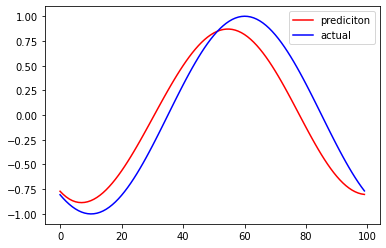

In [20]:
plt.plot(predList, color='r', label='prediciton')
plt.plot(testY, color='b', label="actual")
plt.legend()
plt.show()

In [47]:
'''gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data=X,
    targets=Y,
    length=seqLength,
    stride=1,
    batch_size=cfg['batchSize'],
    shuffle=False)'''

"gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(\n    data=X,\n    targets=Y,\n    length=seqLength,\n    stride=1,\n    batch_size=cfg['batchSize'],\n    shuffle=False)"